<font size="5"><b>Описание проекта</b></font>

**Цель** - разобраться в причинах убытков и помочь компании выйти в плюс.

**Задачи:**
- выяснить откуда приходят пользователи и какими устройствами они пользуются
- выяснить сколько стоит привлечение пользователей из различных рекламных каналов
- выяснить сколько денег приносит каждый клиент
- выяснить когда расходы на привлечение клиента окупаются
- выяснить какие факторы мешают привлечению клиентов

**Описание данных:**

*Данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:*
- лог сервера с данными об их посещениях - файл "visits_info_short.csv",
- выгрузка их покупок за этот период - файл "orders_info_short.csv",
- рекламные расходы - файл "costs_info_short.csv".

*Структура visits_info_short.csv:*
- `User Id` — уникальный идентификатор пользователя
- `Region` — страна пользователя
- `Device` — тип устройства пользователя
- `Channel` — идентификатор источника перехода
- `Session` Start — дата и время начала сессии
- `Session` End — дата и время окончания сессии

*Структура orders_info_short.csv:*
- `User Id` — уникальный идентификатор пользователя
- `Event Dt` — дата и время покупки
- `Revenue` — сумма заказа.

*Структура costs_info_short.csv:*
- `dt` — дата проведения рекламной кампании
- `Channel` — идентификатор рекламного источника
- `costs` — расходы на эту кампанию



<a id="introduction"></a>

**План работ:**

- [Изучение общей информации, предобработка данных](#start)
- [Создание функций для расчета и анализа LTV, ROI, удержания и конверсии](#preprocessing)
- [Исследовательский анализ данных](#analyzing)
- [Изучение маркетинга приложения](#marketing)
- [Оценка окупаемости рекламы](#value)
- [Вывод](#end)

### Изучение общей информации, предобработка данных

<a id="start"></a>
[Описание проекта](#introduction)

In [3]:
#Импортируем библиотеку Pandas
import pandas as pd
#Импортируем модули из библиотеки для работы со временем
from datetime import datetime, timedelta
#Импортируем модуль pyplot библиотеки matplotlib
from matplotlib import pyplot as plt
#Импортируем библиотеку Numpy
import numpy as np

In [4]:
#Сохраняем датафреймы в соответсвующих переменных
visits = pd.read_csv('visits_info_short.csv')
orders = pd.read_csv('orders_info_short.csv')
costs = pd.read_csv('costs_info_short.csv')

#### Датасет "visits"

In [5]:
#Изучим общую информацию о датасете
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


- Пропусков нету
- Необходимо перевести столбцы "Session Start" и "Session End" в тип datetime
- Необходимо привести названия колонок датасета к правильному регистру

In [6]:
#Изучим первые пять строк датасета
visits.head()

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


In [7]:
#Проверим датасет на наличие строк дубликатов
visits.duplicated().sum()

0

Дубликатов не обнаружилось

In [8]:
#Приведем столбцы к правильному регистру
visits.columns = ['user_id', 'region', 'device', 'channel', 'session_start', 'session_end']

In [9]:
#Переведем столбцы "Session Start" и "Session End" в тип datetime
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

In [10]:
#Перепровер информацию о датасете
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


#### Датасет "orders"

In [11]:
#Изучим общую информацию о датасете
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


- Пропусков нету
- Необходимо перевести столбец "Event Dt" в тип datetime
- Необходимо привести названия колонок датасета к правильному регистру

In [12]:
#Изучим первые пять строк датасета
orders.head()

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [13]:
#Проверим датасет на наличие строк дубликатов
orders.duplicated().sum()

0

Дубликатов не обнаружилось

In [14]:
#Приведем столбцы к правильному регистру
orders.columns = ['user_id', 'event_dt', 'revenue']

In [15]:
#Переведем столбец "event_dt" в тип datetime
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

In [16]:
#Перепроверим информацию о датасете
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


#### Датасет "costs"

In [17]:
#Изучим общую информацию о датасете
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


- Пропусков нету
- Необходимо перевести столбец "dt" в тип date
- Необходимо привести название колонки датасета "Channel" к правильному регистру

In [18]:
#Изучим первые пять строк датасета
costs.head()

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [19]:
#Проверим датасет на наличие строк дубликатов
costs.duplicated().sum()

0

Дубликатов не обнаружилось

In [20]:
#Приведем столбцы к правильному регистру
costs.columns = ['dt', 'channel', 'costs']

In [21]:
#Переведем столбец 'dt' в тип date
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

In [22]:
#Перепроверим информацию о датасете
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


### Создание функций для расчёта и анализа LTV, ROI, удержания и конверсии

<a id="preprocessing"></a>
[Описание проекта](#introduction)

#### Функции для вычисления значений метрик

In [23]:
#Зададим фунцию для создания пользовательских профилей с датой первого посещения и источником перехода на сайт

def get_profiles(sessions, orders, events, ad_costs, event_names=[]):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
    for event in event_names:
        if event in events['event_name'].unique():
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [24]:
#Зададим функцию для расчета параметра retention rate, а также формирования таблицы удержания
def get_retention(profiles, sessions, observation_date, horizon_days, dimensions = [], ignore_horizon = False):
    
    # решаем какие столбцы оставим для группировки удержания, столбец признака платящего пользователя остается всегда
    dimensions = ['payer'] + dimensions
    
    # оттсекаем всех пользователей, которые не могли "дожить" до нужного горизонта 
    # (присоединились позже чем observation_date - horizon)
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days = horizon_days - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # формируем массив сырых данных
    result_raw = result_raw.merge(sessions[['user_id', 'session_start']], on = 'user_id', how = 'left')
    result_raw['lifetime'] = (result_raw['session_start'] - result_raw['first_ts']).dt.days
    
    # функция группировки по нужному набору измерений
    def group_by_dimensions(df, dims, horizon_days):     
        result = df.pivot_table(index = dims, columns = 'lifetime', values = 'user_id', aggfunc = 'nunique')     # строим "треугольную таблицу" 
        cohort_sizes = df.groupby(dims).agg({'user_id': 'nunique'}).rename(columns = {'user_id': 'cohort_size'}) # определяем размеры когорт
        result = cohort_sizes.merge(result, on = dims, how = 'left').fillna(0)                                   # присоединяем размеры когорт к треугольной таблице
        result = result.div(result['cohort_size'], axis = 0)                                                     # делим каждый из столбцов на размер когорты - расчитываем % удержания (retention rate)
        result = result[['cohort_size'] + list(range(horizon_days))]                                             # оставляем только наблюдения до нужного горизонта и столбец размеров когорт
        result['cohort_size'] = cohort_sizes                                                                     # пересприсваиваем столбец размеров когорт, ведь во время деления он превратился в 1
        return result
    
    # расчитываем удержание 
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
    
    # рассчитываем удержание по всем параметрам + дата
    result_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)
    
    # возвращаем и таблицы удержания и сырые данные (чтобы в случае чего можно было в них покопаться при отладке)
    return result_raw, result_grouped, result_in_time


In [25]:
#Зададим функцию для подсчета конверсии
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу конверсии
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        # считаем сумму с накоплением для каждой строки
        result = result.fillna(0).cumsum(axis = 1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # добавляем размеры когорт в таблицу конверсии
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [26]:
#Зададим функцию для расчёта пожизненной ценности, а также окупаемости инвестиций
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # сохраняем в датафрейм данные пользователей и значения CAC, 
        # добавив параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

#### Функции для построения графиков:

In [27]:
# Зададим функцию для сглаживания фрейма с недельным окном.
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [28]:
#Зададим функцию для построения графика Retention Rate
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в четвёртой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [29]:
#Зададим функцию для визуализации конверсии
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()


In [30]:
#Зададим функцию для построения графиков отражающих динамику метрик LTV и ROI
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### Исследовательский анализ данных

<a id="analyzing"></a>
[Описание проекта](#introduction)

#### Таблица пользовательских профилей

In [31]:
events = None #Установим None — чтобы не «сломать» get_profiles()

#Составляем профили пользователей
users = get_profiles(visits, orders, events, costs)
users.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [32]:
#Минимальная дата привличения пользователей
min_date = users['dt'].min()
#Максимальная дата привличения пользователей
max_date = users['dt'].max()
print('Минимальная дата:', min_date)
print('Максимальная дата:', max_date)

Минимальная дата: 2019-05-01
Максимальная дата: 2019-10-27


Даты привлечения пользователей из датасета совпадают со сроками, которые нам были указаны в условиях проекта.

#### Рейтинг по странам

In [33]:
users_reg = users.groupby('region').agg({'user_id': 'count', 'payer': 'sum'}).rename(columns={'user_id': 'count_of_users'})
users_reg['share_of_payer'] = round(users_reg['payer'] / users_reg['count_of_users'] * 100, 2)
users_reg.sort_values(by='share_of_payer', ascending=False)

,count_of_users,payer,share_of_payer
region,,,
United States,100002,6902,6.90
Germany,14981,616,4.11
UK,17575,700,3.98
France,17450,663,3.80


*Выводы по таблице:*
- Основная аудитория нашего приложения находится в Соединенных Штатах - `100 002` уникальных пользователей
- Меньше всего пользователей наших пользователей находится в Германии - `14 981` уникальных пользователей
- Больше всего доля платящих пользователей у Соединенных Штатов - `6.9%`
- Меньше всего платящих клиентов у Франции - `3.8%`

#### Рейтинг по устройствам

In [34]:
users_dev = users.groupby('device').agg({'user_id': 'count', 'payer': 'sum'}).rename(columns={'user_id': 'count_of_users'})
users_dev['share_of_payer'] = round(users_dev['payer'] / users_dev['count_of_users'] * 100, 2)
users_dev.sort_values(by='share_of_payer', ascending=False)

,count_of_users,payer,share_of_payer
device,,,
Mac,30042,1912,6.36
iPhone,54479,3382,6.21
Android,35032,2050,5.85
PC,30455,1537,5.05


*Выводы по таблице:*
- Больше всего пользователей пользуются устройствами iPhone - `54 479` уникальных пользователей
- Меньше всего пользователей пользуются устройствами Mac - `30 042` уникальных пользователей
- Больше всего платящих клиентов пользуются устройствами Mac - `6.36%`
- Меньше всего платящих клиентов пользуются персональными компьютерами - `5.05%`

#### Рейтинг по источникам привлечения

In [35]:
users_chan = users.groupby('channel').agg({'user_id': 'count', 'payer': 'sum'}).rename(columns={'user_id': 'count_of_users'})
users_chan['share_of_payer'] = round(users_chan['payer'] / users_chan['count_of_users'] * 100, 2)
users_chan.sort_values(by='share_of_payer', ascending=False)

,count_of_users,payer,share_of_payer
channel,,,
FaceBoom,29144,3557,12.20
AdNonSense,3880,440,11.34
lambdaMediaAds,2149,225,10.47
TipTop,19561,1878,9.60
RocketSuperAds,4448,352,7.91
WahooNetBanner,8553,453,5.30
YRabbit,4312,165,3.83
MediaTornado,4364,156,3.57
LeapBob,8553,262,3.06


*Выводы по таблице:*
- Больше всего пользователей нашли наше приложение самостоятельно - `56 439` уникальных пользователей
- Также в самой большой "органической" группе меньше всего доля платящих клиентов - `2.06%`
- Больше всего платящих клиентов было привлечено через канал `FaceBoom` - `12.2%`
- Меньше всего пользователей пришло через канал `lambdaMediaAds` - `2 149` уникальных пользователей

ТОП-5 каналов привлечения (в порядке убывания эффективности):
- FaceBoom
- AdNonSense
- lambdaMediaAds
- TipTop
- RocketSuperAds	

### Изучение маркетинга приложения

<a id="marketing"></a>
[Описание проекта](#introduction)

#### Общая сумма расходов на маркетинг

In [36]:
round(costs['costs'].sum(), 1)

105497.3

Общая сумма расходов на маркетинг составила - 105 497.3 у.е.

#### Распределение трат по рекламным источникам

In [37]:
costs_grouped = costs.groupby('channel').agg({'costs': 'sum'})
costs_grouped.sort_values(by='costs', ascending = False)

,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


*Выводы по таблице:*
- Самые большие траты рекламного бюджета были потрачены на источник `TipTop` - `54751.3` у.е
- Меньше всего было потрачено на `YRabbit` - `944.22` у.е 

#### Динамика изменения расходов во времени

In [38]:
#Добавим в датасет 'costs' столбцы с неделями и месяцами для построения графиков
costs['week'] = pd.to_datetime(costs['dt']).dt.isocalendar().week
costs['month'] = pd.to_datetime(costs['dt']).dt.month

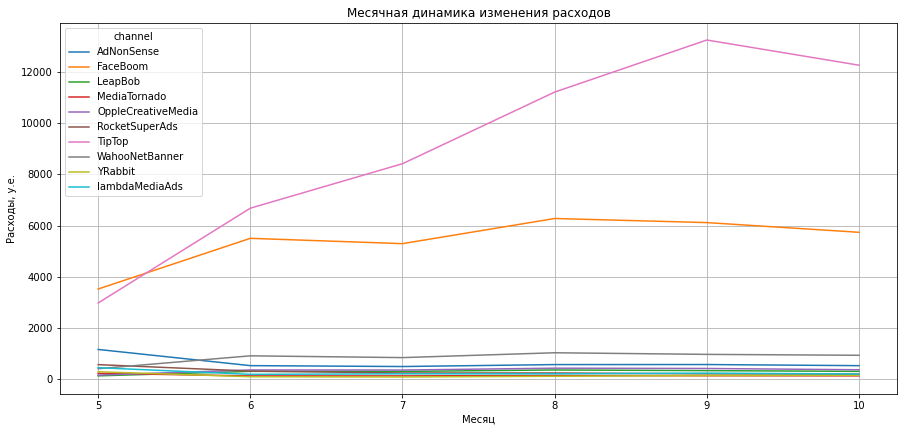

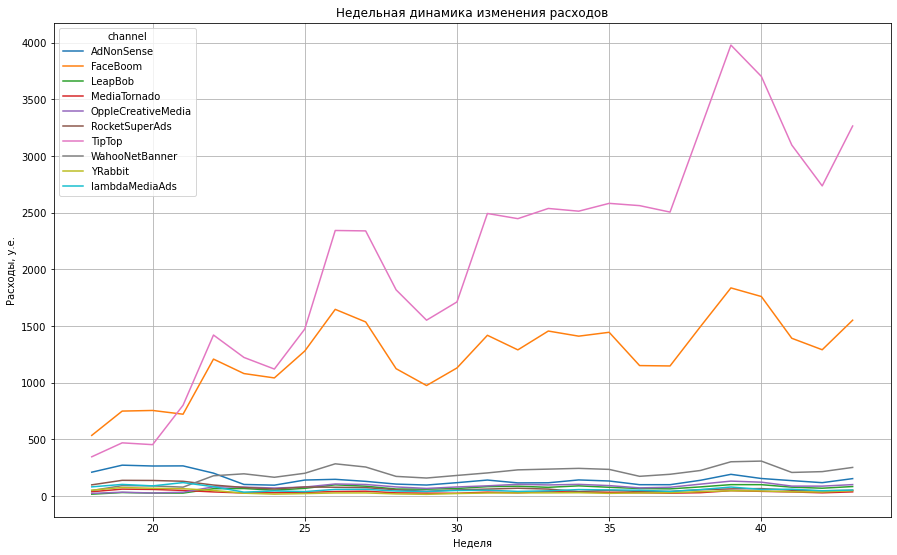

In [39]:
#Сделаем сводную таблицу по затратам на один рекламный источник
costs_grouped = costs.pivot_table(
    index=['channel'], columns=['month', 'week'], values='costs', aggfunc='sum')

#Выведем график, отражающий месячные траты на источники
plt.figure()
costs_grouped.droplevel(
    'week', axis=1).groupby(
    level=0, axis=1).sum().T.plot(
    grid=True, figsize=(15,15), ax = plt.subplot(2, 1, 1))
plt.ylabel('Расходы, у.е.')
plt.xlabel('Месяц')
plt.title('Месячная динамика изменения расходов')
plt.show()
#Выведем график, отражающий недельные траты на источники
costs_grouped.droplevel(
    'month', axis=1).groupby(
    level=0, axis=1).sum().T.plot(
    grid=True, figsize=(15,20), ax = plt.subplot(2, 1, 2))
plt.ylabel('Расходы, у.е.')
plt.xlabel('Неделя')
plt.title('Недельная динамика изменения расходов')
plt.show()


*Выводы по графикам:*
- На протяжении всего рассматриваемого периода было 2 лидера по затратам: `TipTop`, `FaceBoom`
- За исключением начала рассматриваемого периода (ближе к середине мая) на канал `FaceBoom` тратилось больше средств, чем на `TipTop`
- Остальные источники находятся приблизительно на одном уровне трат и не менялись в течение рассматриваемого периода, в то время, как на каналы `TipTop`, `FaceBoom` затраты только увеличивались.

#### Средняя стоимость привлечения одного пользователя из каждого источника

In [40]:
#Определим для каждого источника стоимость привлечения одного клиента посредством сводной таблицы
ac_per_channel = users.pivot_table(
index=['channel'], values='acquisition_cost').sort_values(by='acquisition_cost', ascending=False)
#Округлим значения в таблице до двух знаков для более удобного чтения результатов
round(ac_per_channel['acquisition_cost'], 2)

channel
TipTop                2.80
FaceBoom              1.11
AdNonSense            1.01
lambdaMediaAds        0.72
WahooNetBanner        0.60
RocketSuperAds        0.41
OppleCreativeMedia    0.25
YRabbit               0.22
MediaTornado          0.22
LeapBob               0.21
organic               0.00
Name: acquisition_cost, dtype: float64

*Выводы по таблице:*

- Самый дорогой пользователь у источника `TipTop` - 2.8 у.е - это в ~2.5 раза больше, чем у второго лидера по расходам `FaceBoom` - 1.11 у.е.
- Меньше всего расходов на одного пользователя приходится у источника `LeapBob` - 0.21 у.е.

### Оценка окупаемости рекламы

<a id="value"></a>
[Описание проекта](#introduction)

#### Графики LTV и ROI. Графики динамики LTV, CAC и ROI.


In [41]:
#Зададим момент анализа
observation_date = datetime(2019, 11, 1).date()
#Зададим горизонт анализа 
horizon_days = 14

In [42]:
#Из датасета удалим пользователей, которые нашли наше приложение самостоятельно
users = users[users['channel']!='organic']

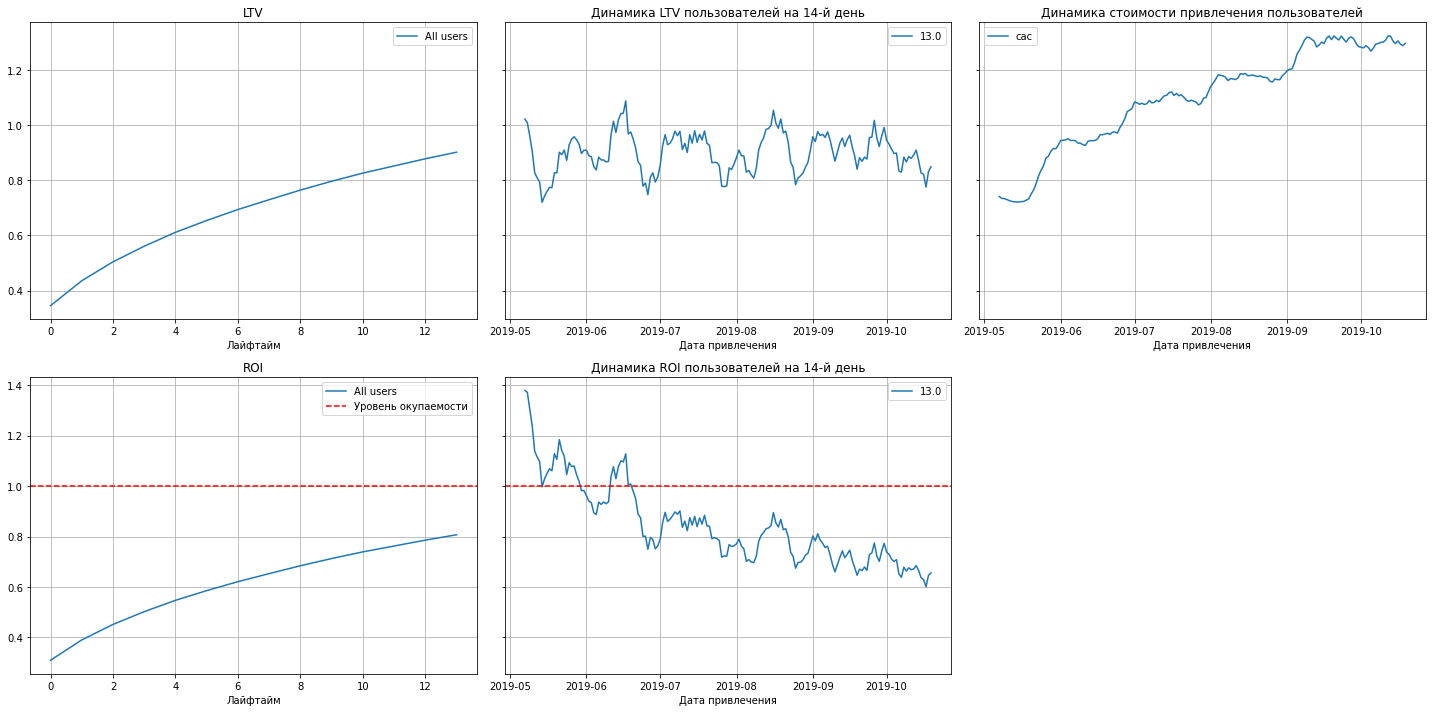

In [43]:
# считаем LTV и ROI
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    users, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days)

*Выводы по графикам:*
- Общие затраты на рекламу не окупаются. ROI в конце недели — около 80%, но уровень окупаемости не проходит
- CAC на протяжении рассматриваемого периода постоянно рос (возможно снижение затрат на маркетинг повысят окупаемость)
- На LTV влияет сезонный фактор, но и этот показатель достаточно стабилен. Значит, дело не в ухудшении качества пользователей

#### Изучение конверсии и удержания пользователей

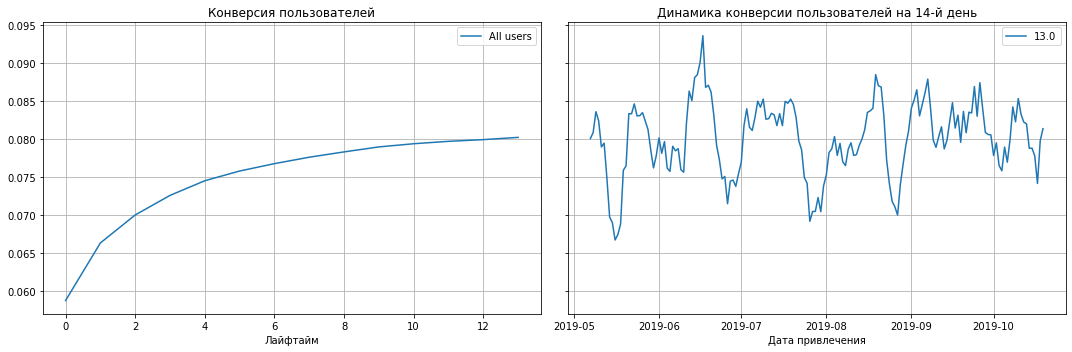

In [44]:
# смотрим конверсию с разбивкой по устройствам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    users, orders, observation_date, horizon_days
)
# строим графики
plot_conversion(conversion_grouped, conversion_history, horizon_days) 

*Выводы по графикам:*
Динамика конверсии имеет сезонный характер

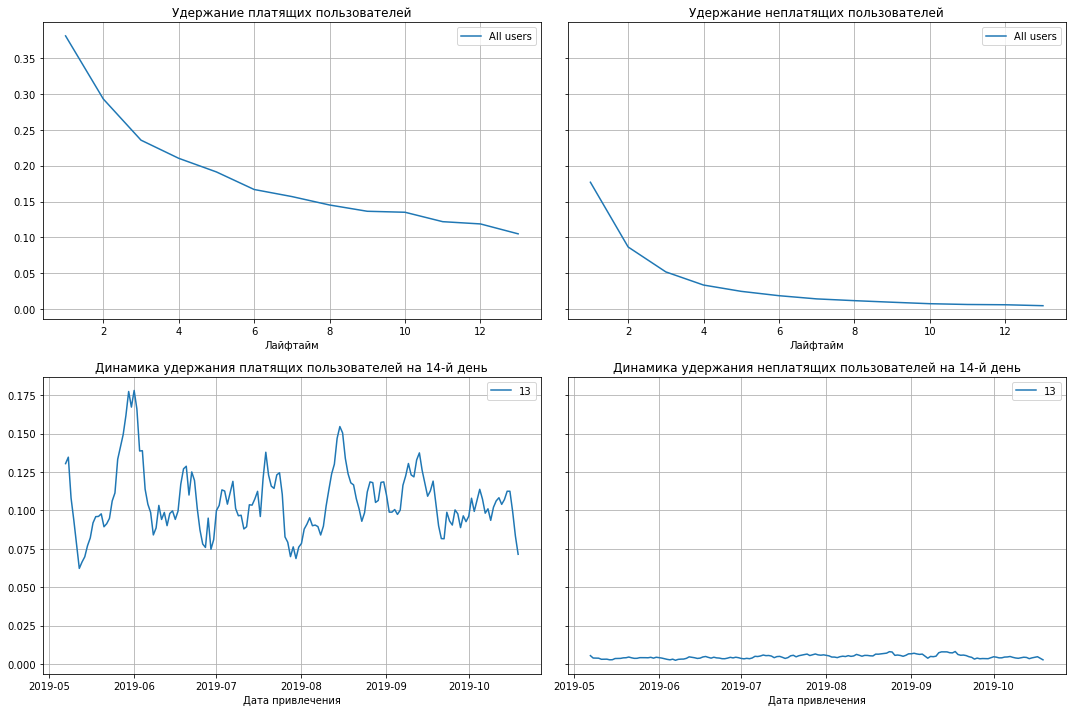

In [45]:
# смотрим удержание с разбивкой по устройствам

retention_raw, retention_grouped, retention_history = get_retention(
    users, visits, observation_date, horizon_days
)

# строим графики
plot_retention(retention_grouped, retention_history, horizon_days) 

*Выводы по графикам:*
Как и ожидалось, удержание для платящих пользователей выше, чем для неплатящих.

#### Графики LTV и ROI. Графики динамики LTV, CAC и ROI. Разбивка по устройствам


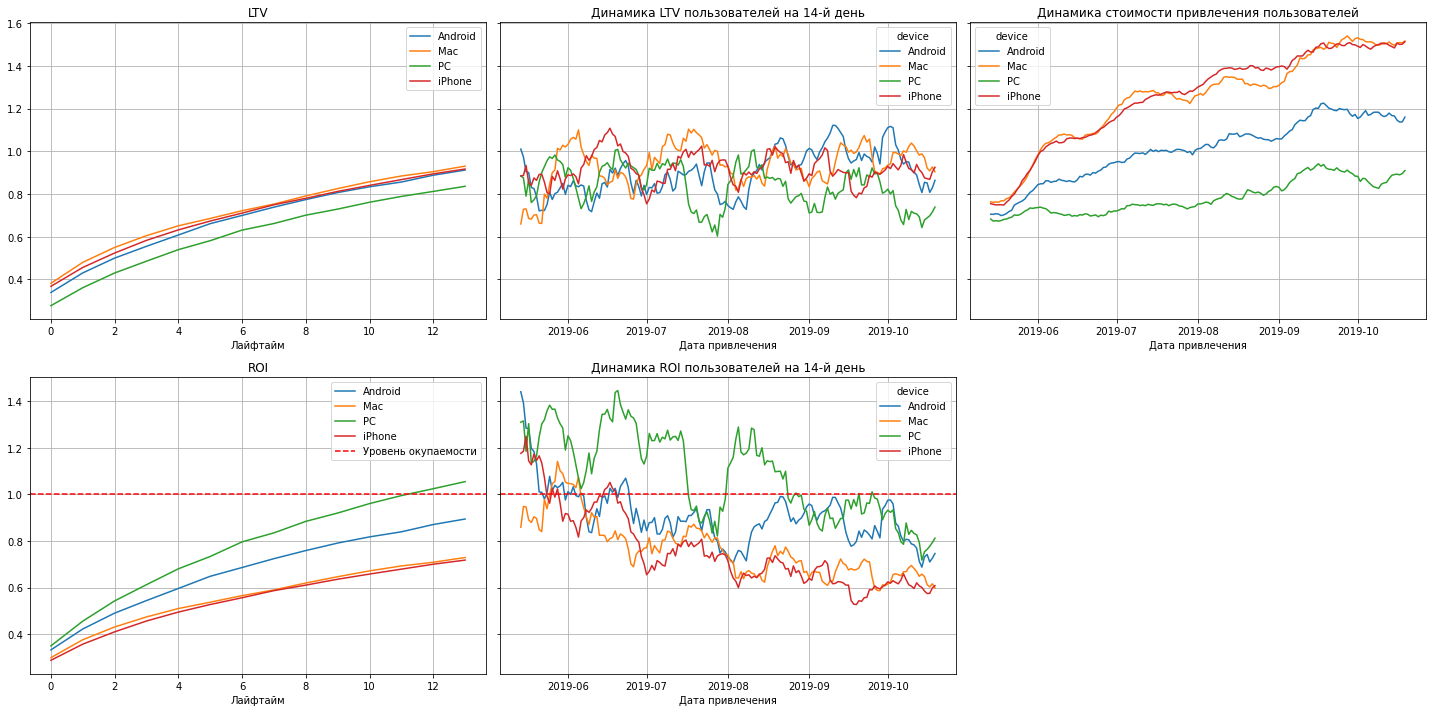

In [46]:
# считаем LTV и ROI
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    users, orders, observation_date, horizon_days, dimensions=['device']
)

# строим графики
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=14)

*Выводы по графикам:*
- Практически одинаково стабильно не окупаются пользователи, которые обладают устройствами от компании Apple (Mac, iPhone) - ROI около 90%. При этом динамика стоимости их привлечения самая высокая. Динамика стоимости их привлечения приблизительно одинаково растет.
- Лучше и стабильнее всего окупаются пользователи, которые пользуются приложением через персональные компьютеры.

#### Графики LTV и ROI. Графики динамики LTV, CAC и ROI. Разбивка по странам

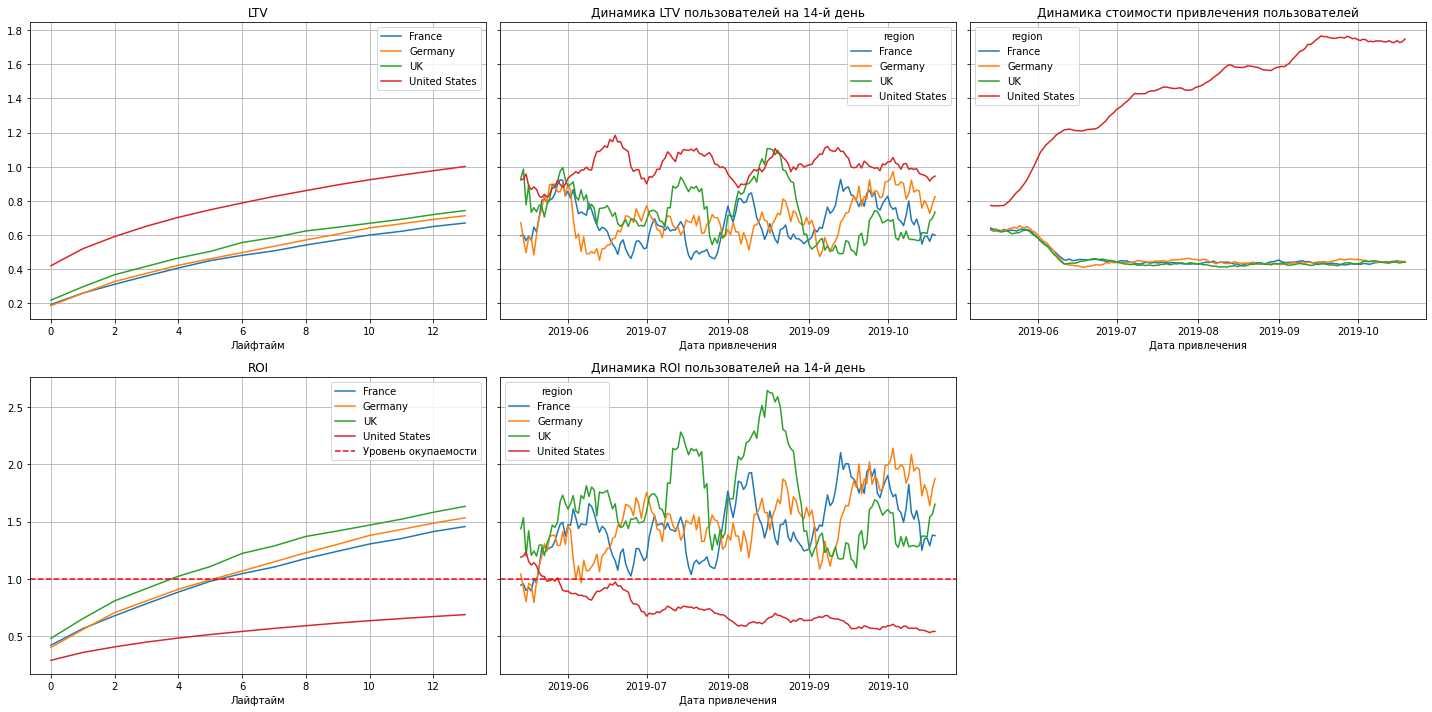

In [47]:
# считаем LTV и ROI
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    users, orders, observation_date, horizon_days, dimensions=['region']
)

# строим графики
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=14)

*Выводы по графикам:*
- Стабильно окупаются пользователи из регионов: Великобритании, Германии и Франции. Пользователи из Соединенных штатов не окупаются совсем, причина может крыться в слишком высоких расходах на привлечение пользователей из этого региона (Динамика стоимости растет от месяца к месяцу, но при этом уровень окупаемости не переваливает за 100%). Тем не менее, LTV пользователей из Соединенных штатов самый высокий.
- Пользователи из Великобритании(UK) окупаются лучше всего.

#### Графики LTV и ROI. Графики динамики LTV, CAC и ROI. Разбивка по рекламным каналам

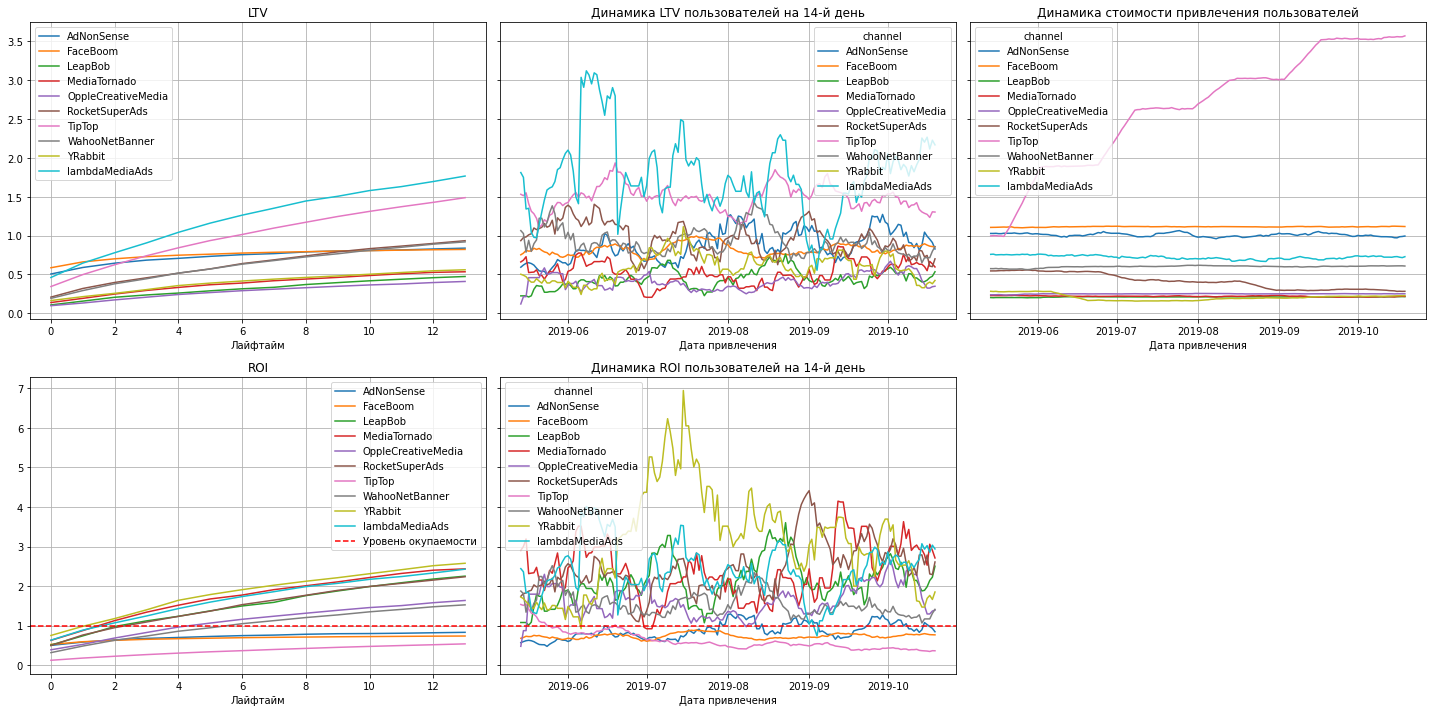

In [48]:
# считаем LTV и ROI
#Исключим органический канал привлечения
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    users, orders, observation_date, horizon_days, dimensions=['channel']
)

# строим графики
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=14)

*Выводы по графикам:*
- Самые дорогие источники привлечения:
    - `TipTop`
    - `FaceBoom`
    - `AdNonSense`
- Эти же самые источники не доходят до уровня окупаемости, хотя на остальные источники тратят меньше средств, но они окупаются.
- Отдельно стоит выделить рекламный канал `TipTop` - На протяжении всего рассматриваемого промежутка времени, динамика стоимости привлечения пользователей только росла, но при этом у него самый низкий показатель окупаемости.
- С самого начала рассматриваемого периода динамика окупаемости для рекламных источников `TipTop` и `FaceBoom` не выходила за черту окупаемости.
- Самым окупаемым рекламным каналом является источник `YRabbit`

#### Изучение конверсии и удержания по параметрам

##### Анализ по устройствам

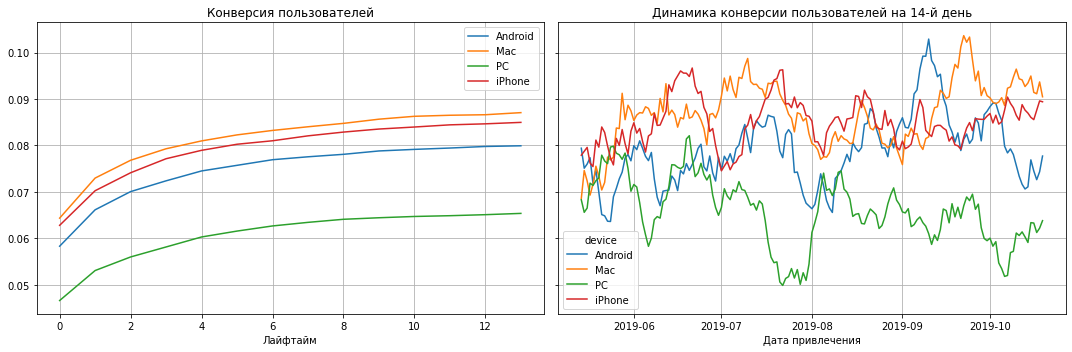

In [49]:
# смотрим конверсию с разбивкой по устройствам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    users, orders, observation_date, horizon_days, dimensions=['device']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days, window=14) 

Пользователи конвертируются стабильно хорошо на устройствах Mac и Iphone, возможно дело в удержании?

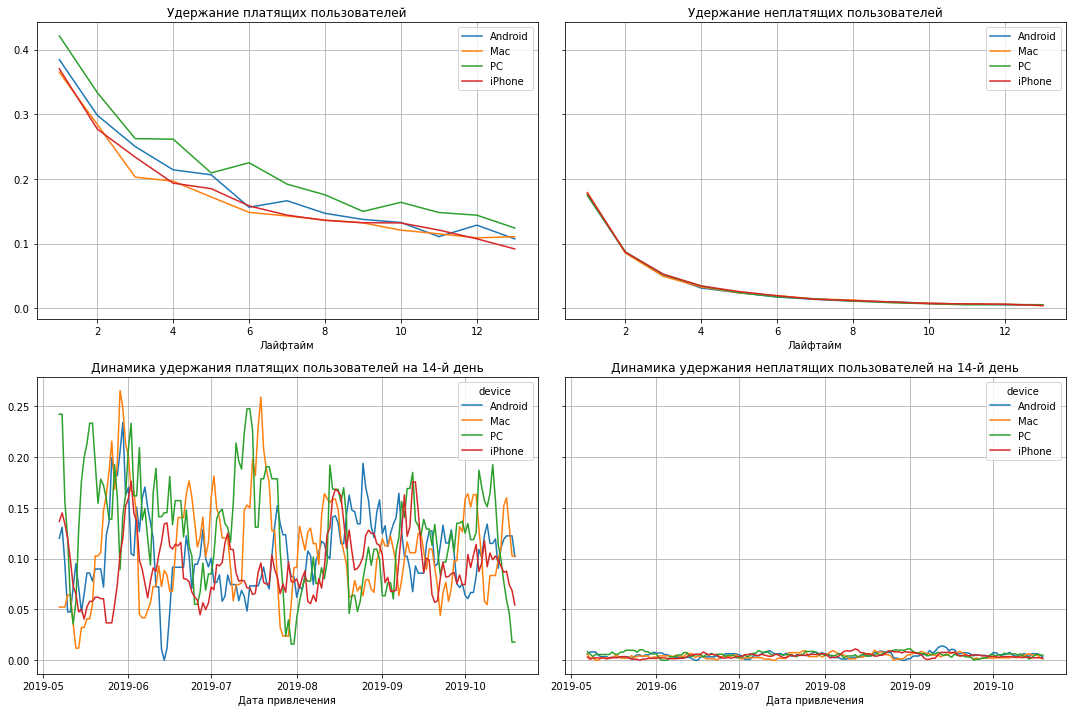

In [50]:
# смотрим удержание с разбивкой по устройствам

retention_raw, retention_grouped, retention_history = get_retention(
    users, visits, observation_date, horizon_days, dimensions=['device']
)

plot_retention(retention_grouped, retention_history, horizon_days) 

С удержанием на этих устройствах также все в порядке, значит дело не в них

##### Анализ по регионам

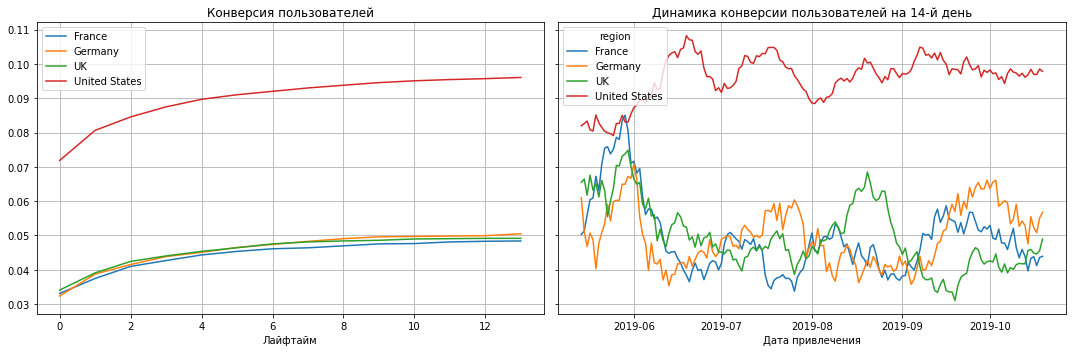

In [51]:
# смотрим конверсию с разбивкой по регионам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    users, orders, observation_date, horizon_days, dimensions=['region']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days, window=14)

Пользователи из региона который окупается хуже всех, конвертируются лучше всех, возможно, дело в удержании?

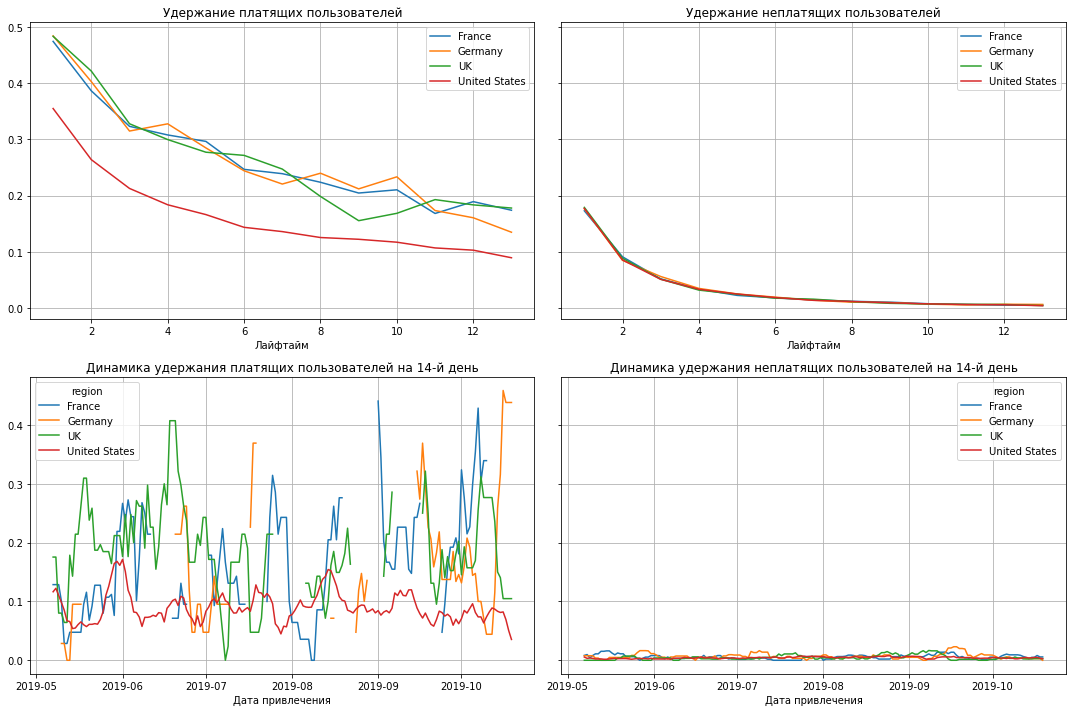

In [52]:
# смотрим удержание с разбивкой по регионам

retention_raw, retention_grouped, retention_history = get_retention(
    users, visits, observation_date, horizon_days, dimensions=['region']
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Действительно, удержание пользователей из этого региона значительно ниже, возможно они имеют проблемы с доступом в приложение за счет далекого расположения серверов с приложением или иных технических причин.

##### Анализ по каналам привлечения

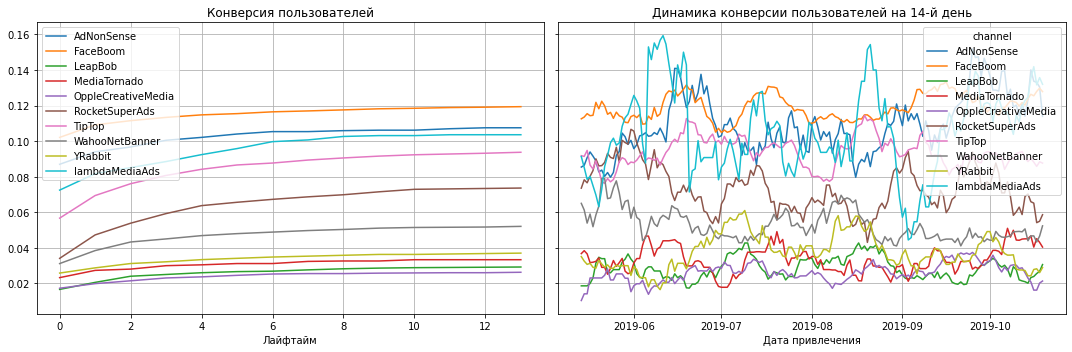

In [53]:
# смотрим конверсию с разбивкой по каналам привлечения

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    users, orders, observation_date, horizon_days, dimensions=['channel']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days, window=14) 

Источники, которые не окупаются, а именно:
- `TipTop`
- `FaceBoom`
- `AdNonSense`

Имеют лучшие конверсионные показатели, возможно дело в удержании?

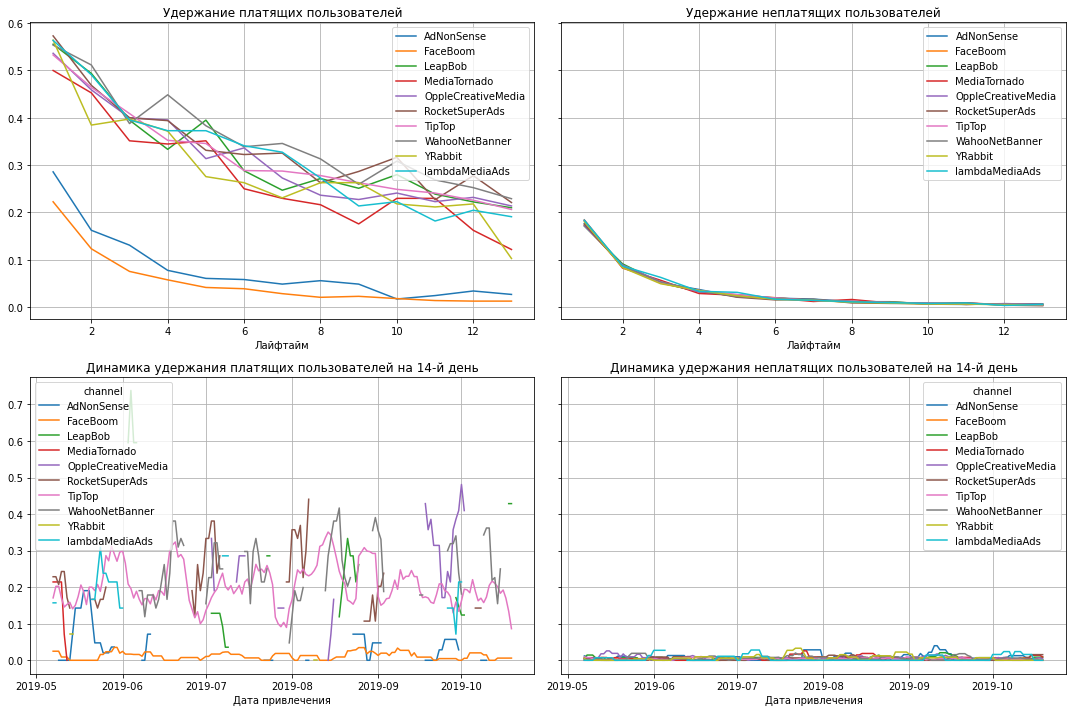

In [54]:
# смотрим удержание с разбивкой по каналам привлечения
#Исключим органический канал привлечения
retention_raw, retention_grouped, retention_history = get_retention(
    users, visits, observation_date, horizon_days, dimensions=['channel']
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Действительно, у источника `FaceBoom` и `AdNonSense`, очень низкие показатели удержания платящих пользователей, возможно дело в какой - то технической проблеме и при переходе через эти источники у пользователей возникают проблемы с приложением. У `TipTop` удержание схоже с удержанием других, не отходящих от нормы, каналов.

### Выводы

<a id="end"></a>
[Описание проекта](#introduction)

Окупается ли реклама, направленная на привлечение пользователей в целом?
- Реклама не окупается - ROI по всем пользователям не превышает единицы.

Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
- Соединенные штаты оказывают негативное влияние на окупаемость;
- Пользователи с устройствами от Apple (Mac и Iphone) оказывают негативное влияние на окупаемость;
- Каналы:`TipTop` `FaceBoom` `AdNonSense`, - оказывают негативное влияние на окупаемость.

Чем могут быть вызваны проблемы окупаемости?
- Удержание пользователей из Соединенных штатов значительно ниже, чем у пользователей из других регионов, возможно они имеют проблемы с доступом в приложение за счет далекого расположения серверов с приложением или иных технических причин.
- Возможно, пользователи с устройствами от Apple (Mac и Iphone) имеют технические проблемы с доступом в приложение, или же реклама на этих устройствах не эффективна.
- у источников FaceBoom и AdNonSense, очень низкие показатели удержания платящих пользователей, возможно дело в какой - то технической проблеме и при переходе через эти источники у пользователей возникают проблемы с приложением. У TipTop удержание схоже с удержанием других, не отходящих от нормы, каналов, возможно сам по себе канал неэффективен.

**Рекламные источники**

Пользователи, которые пришли к нам через каналы привлечения с самым высоким финансированием (и самой высокой стоимостью привлечения одного пользователя, соответсвенно) имеют низкие показатели удержания и низкие показатели окупаемости.
Средняя цена привлечения одного пользователя:
 - TipTop - 2.80 у.е
 - FaceBoom - 1.11 у.е
 - AdNonSense - 1.01 у.е
 
Всего трат на канал привлечения:
- TipTop - 54751.30 у.е
- FaceBoom - 32445.60 у.е
- AdNonSense - 3911.25 у.е

`Возможная причина неэффективности №1 - инвестирование в неподходящие рекламные источники`

`Возможная причина неэффективности №2 - технические проблемы с рекламными источниками`

**Страны**

Несмотря на то, что наша основная аудитория приложения находится в Соединенных Штатах - 100 002 уникальных пользователей и больше всего доля платящих пользователей приходится именно на эту страну - 6.9%, удержание пользователей из Соединенных штатов значительно ниже, чем у пользователей из других регионов, возможно они имеют проблемы с доступом в приложение за счет далекого расположения серверов с приложением или иных технических причин.

`Возможная причина неэффективности №3 - технические проблемы на территории Соединенных штатов`

`Возможная причина неэффективности №4 - высокие расходы на рекламу в Соединенных штатах`

**Устройства**

Возможно, пользователи с устройствами от Apple (Mac и Iphone) имеют технические проблемы с доступом в приложение (маловероятно), или же в реклама на этих устройствах переоценена и стоит сократить расходы рекламы на этих устройствах.
 - Mac - 6.36%
 - iPhone - 6.21%
 - Android - 5.85%
 - PC - 5.05%
 
`Возможная причина неэффективности №5 - высокие расходы на рекламу для устройств: iPhone, Mac`

`Возможная причина неэффективности №6 - технические проблемы у обладателей устройств: iPhone, Mac`

**Рекомендации для отдела маркетинга в порядке важности:**
1) Изучить источники `FaceBoom` и `AdNonSense` на предмет наличия технических проблем (потому что при плохом удержании эти каналы имеют самые высокие показатели конверсии и динамики ее удержания);

2) Если с каналом `FaceBoom`действительно были какие - то технические проблемы (и их исправили), то стоит подумать над перераспределением рекламного бюджета между источником `TipTop` и `FaceBoom` в сторону второго;

3) Сократить расходы на рекламу в `Соединенных штатах` на канал `TipTop` (при не самых лучших показателях этот канал имеет самую дорогую стоимость привлечения одного пользователя - `2.8` у.е, также не окупается);

4) Сократить расходы на рекламу для пользователей устройств: `iPhone, Mac`;

5) Изучить возможные технические проблемы, которые могут возникать у пользователей устройств: `iPhone, Mac`;

6) Изучить возможные технические проблемы, которые могут возникать у пользователей на территории `Соединенных штатов`.